In [1]:
import fotd_modules.Metrica_IO as mio
import fotd_modules.Metrica_Viz as mviz
import fotd_modules.Metrica_Velocities as mvel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# pd option to only show 6 rows instead (output to be more concise):
pd.set_option("display.max_rows",6)

In [3]:
"""
Created on Sun Apr  19th.

Script for lesson 5 of "Friends of Tracking" #FoT

Data can also be found at: https://github.com/metrica-sports/sample-data

Accompanying video tutorials can be found here: https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w

GitHub repo: https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking
@author: Laurie Shaw (@EightyFivePoint)
"""

# Set up my initial path to data:
DATADIR = '/PATH/TO/WHERE/YOU/SAVED/THE/SAMPLE/DATA'

# let's look at sample match 2:
game_id = 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# And of course, reading TRACKING DATA
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

Reading team: home
Reading team: away


In [4]:
# Convert positions from metrica units to meters 
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

In [5]:
# reverse direction of play in the second half so that home team is always attacking from right to left (<--)
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

<h3> 1. Making a movie (example used - 2nd home team goal) </h3>

In [6]:
# Making a movie of the second home team goal

#first, where to save the movie (same DIR set up before)
PLOTDIR = DATADIR

# # # Uncomment to save the movie:
# mviz.save_match_clip(tracking_home.iloc[73600:73600+500],tracking_away.iloc[73600:73600+500],
#                      PLOTDIR,fname='home_goal_2',include_player_velocities=False)

<h3> 2. Measuring players speed </h3>

In [7]:
# Calculate player velocities

#**** NOTE *****
# the default filter set in Metrica_Velocities.py (filter_='Savitzky-Golay') produce an error 
# for certain version(s) of numpy, then use the trick below, adding optional arg filter_ = 'moving_average':
#***************
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

In [8]:
tracking_home

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_6_speed,Home_7_vx,Home_7_vy,Home_7_speed,Home_8_vx,Home_8_vy,Home_8_speed,Home_9_vx,Home_9_vy,Home_9_speed
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141154,2,5646.16,46.3379,0.84524,12.19106,-23.55792,29.08852,-5.87860,24.22948,-12.09788,...,0.880845,0.0,0.0,0.0,NaN,NaN,NaN,1.325000,0.840286,1.568982
141155,2,5646.20,46.3379,0.84524,12.19106,-23.55792,29.08852,-5.87860,24.22948,-12.09788,...,0.722296,0.0,0.0,0.0,NaN,NaN,NaN,1.086500,0.757714,1.324618
141156,2,5646.24,46.3379,0.84524,12.19106,-23.55792,29.08852,-5.87860,24.22948,-12.09788,...,0.527263,0.0,0.0,0.0,NaN,NaN,NaN,0.851786,0.675143,1.086902


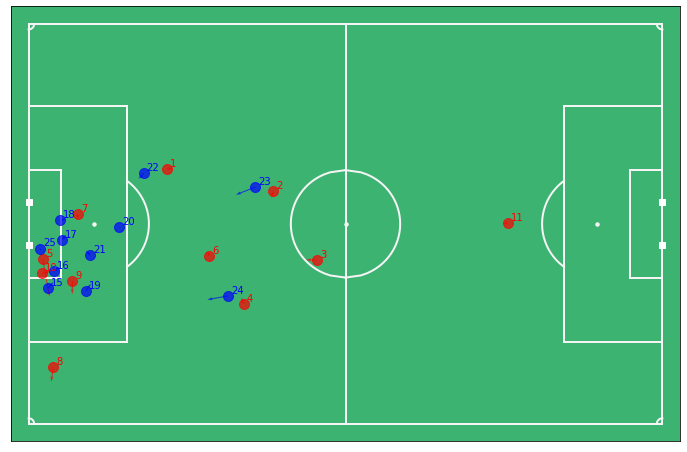

In [9]:
# plot a random frame, plotting the player velocities using quivers
mviz.plot_frame( tracking_home.loc[10000], tracking_away.loc[10000], include_player_velocities=True, annotate=True);

<h3> 3. Physical report/ summary for players of the Home team </h3>

In [10]:
# Create a Physical summary dataframe for home players
home_players = np.unique( [ c.split('_')[1] for c in tracking_home.columns if c[:4] == 'Home' ] )
# c.split('_')[1] identifies the jersey number for each plr in the tracking data

# and then creates a new df where each ROW is a player (index = player; rather than an instant in the game):
home_summary = pd.DataFrame(index=home_players)

In [11]:
home_summary

""
1
10
11
...
7
8
9


<h4> a. Minutes played </h4>

In [12]:
# Calculate minutes played for each player
minutes = []
for player in home_players:
    # search for first and last frames that we have a position observation for each player 
    # (when a player is not on the pitch positions are NaN)
    
    # use player x-position coordinate:
    column = 'Home_' + player + '_x'
    
    player_minutes = ( tracking_home[column].last_valid_index() - tracking_home[column].first_valid_index() + 1 ) / 25 / 60. # convert to minutes
    minutes.append( player_minutes )
    
home_summary['Minutes Played'] = minutes
home_summary = home_summary.sort_values(['Minutes Played'], ascending=False)

In [13]:
home_summary

,Minutes Played
1,94.104000
11,94.104000
2,94.104000
...,...
12,30.302667
13,23.364000
14,10.279333


<h4> b. Distance covered </h4>

In [14]:
# Calculate total distance covered for each player
distance = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_distance = tracking_home[column].sum()/25./1000 # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance.append( player_distance )
home_summary['Distance [km]'] = distance

In [15]:
home_summary

,Minutes Played,Distance [km]
1,94.104000,10.368144
11,94.104000,5.203820
2,94.104000,9.841228
...,...,...
12,30.302667,3.030846
13,23.364000,2.367846
14,10.279333,1.081870


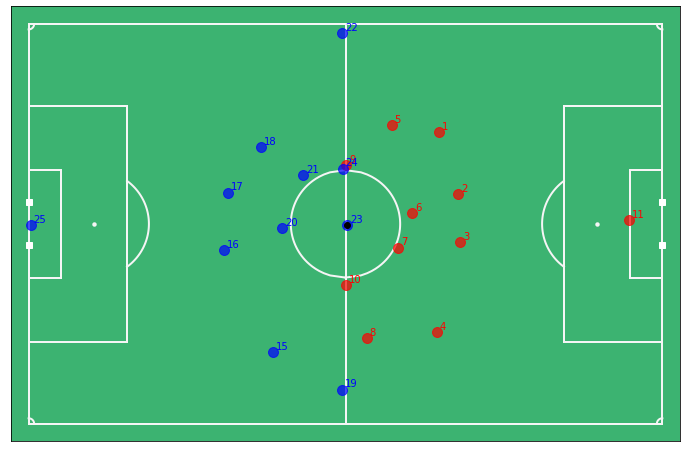

In [16]:
# In case we want to have a look at plr positions (roles) to understand/ explain better the results above,
# plot positions at KO (to find out what position each player is playing)
mviz.plot_frame( tracking_home.loc[51], tracking_away.loc[51], include_player_velocities=False, annotate=True);

# e.g. no 11 is the GK of the home team (only 5.2 km in the game, unsurprisingly)

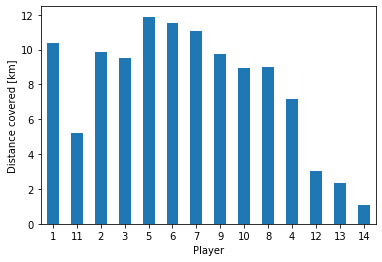

In [17]:
# make a simple bar chart of distance covered for each player
plt.subplots()
ax = home_summary['Distance [km]'].plot.bar(rot=0)
ax.set_xlabel('Player')
ax.set_ylabel('Distance covered [km]');

<h4> c. Different speeds (Running types) </h4>
<li> walking 0-2 m/s </li>
<li> jogging 2-4 m/s </li>
<li> running 4-5.5 m/s </li>
<li> sprinting 5.5-7 m/s </li>
<li> high intensity sprinting 7+ m/s </li> 

In [18]:
# now calculate distance covered while: walking, joggings, running, sprinting & high intensity sprinting
walking = []
jogging = []
running = []
sprinting = []
hi_sprinting = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_home.loc[tracking_home[column] < 2, column].sum()/25./1000
    walking.append( player_distance )
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 2) & (tracking_home[column] < 4), column].sum()/25./1000
    jogging.append( player_distance )
    # running (between 4 and 5.5 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 4) & (tracking_home[column] < 5.5), column].sum()/25./1000
    running.append( player_distance )
    # sprinting (between 5.5 and 7 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 5.5) & (tracking_home[column] < 7), column].sum()/25./1000
    sprinting.append( player_distance )
    # high intensity sprinting (greater than 7 m/s)
    player_distance = tracking_home.loc[ tracking_home[column] >= 7, column].sum()/25./1000
    hi_sprinting.append( player_distance )
    
home_summary['Walking [km]'] = walking
home_summary['Jogging [km]'] = jogging
home_summary['Running [km]'] = running
home_summary['Sprinting [km]'] = sprinting
home_summary['HI Sprinting [km]'] = hi_sprinting

In [19]:
home_summary

,Minutes Played,Distance [km],Walking [km],Jogging [km],Running [km],Sprinting [km],HI Sprinting [km]
1,94.104000,10.368144,3.701845,4.434964,1.635079,0.513543,0.082712
11,94.104000,5.203820,4.394682,0.777765,0.028451,0.001204,0.001718
2,94.104000,9.841228,4.085793,4.066061,1.355765,0.255448,0.078159
...,...,...,...,...,...,...,...
12,30.302667,3.030846,1.140285,1.033643,0.559144,0.258443,0.039331
13,23.364000,2.367846,0.873984,0.857783,0.419021,0.161560,0.055498
14,10.279333,1.081870,0.436613,0.402641,0.199641,0.034853,0.008121


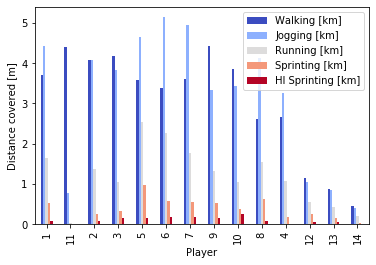

In [20]:
# make a clustered bar chart of distance covered for each player at each speed
ax = home_summary[['Walking [km]','Jogging [km]','Running [km]','Sprinting [km]', 'HI Sprinting [km]']].plot.bar(colormap='coolwarm')
ax.set_xlabel('Player')
ax.set_ylabel('Distance covered [m]');

<h4> (focus on) Number of high intensity <u> sustained </u> sprints </h4>

In [21]:
'''
sustained sprints: 
how many sustained sprints per match did each player complete? 
Defined as maintaining a speed > 7 m/s for at least 1 second
'''
n_hi_sprints = []
sprint_threshold = 7 # minimum speed to be defined as a sprint (m/s)
sprint_window = 1*25 # minimum duration sprint should be sustained (in this case, 1 second = 1000msec i.e. 25 consecutive frames)
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # trick here is to convolve speed with a window of size 'sprint_window', and 
    # find number of occassions that sprint was sustained for at least one window length!
    # diff (again) helps us to identify when the window starts
    player_sprints = np.diff( 1*( 
        np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) 
                            )
    
    n_hi_sprints.append( np.sum( player_sprints == 1 ) )
    
home_summary['# high intensity sprints'] = n_hi_sprints

In [22]:
# Reset pd option to be able to see the number of high intensity sprints for each player of the home team:
pd.reset_option("display.max_rows")
home_summary

,Minutes Played,Distance [km],Walking [km],Jogging [km],Running [km],Sprinting [km],HI Sprinting [km],# high intensity sprints
1,94.104000,10.368144,3.701845,4.434964,1.635079,0.513543,0.082712,5
11,94.104000,5.203820,4.394682,0.777765,0.028451,0.001204,0.001718,0
2,94.104000,9.841228,4.085793,4.066061,1.355765,0.255448,0.078159,3
3,94.104000,9.539809,4.178312,3.832495,1.055999,0.325245,0.147757,8
5,94.104000,11.891429,3.583712,4.651715,2.541026,0.974204,0.140772,8
6,94.104000,11.534779,3.385473,5.144969,2.255724,0.573161,0.175454,7
7,94.104000,11.068171,3.606788,4.956883,1.774945,0.549389,0.180165,9
9,94.104000,9.765225,4.428081,3.322470,1.329811,0.533710,0.151153,7
10,83.825333,8.947584,3.858223,3.429603,1.033055,0.367442,0.259261,14
8,70.740667,9.007497,2.604774,4.133736,1.553444,0.628854,0.086690,6


<h4> Where these high intensity sprints occured </h4> (example with player 8) 

In [23]:
# Plot the trajectories for each of player 8's (distinct) sprints
player = '8'
column = 'Home_' + player + '_speed' # spped
column_x = 'Home_' + player + '_x' # x position
column_y = 'Home_' + player + '_y' # y position

# same trick as before to find start and end indices of windows of size 'sprint_window' in which 
# player speed was above the sprint_threshold:
player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), 
                                          np.ones(sprint_window), mode='same' ) >= sprint_window ) )

# adding sprint_window/2 because of the way that the convolution is centred:
player_sprints_start = np.where( player_sprints == 1 )[0] - int(sprint_window/2) + 1 
player_sprints_end = np.where( player_sprints == -1 )[0] + int(sprint_window/2) + 1


In [24]:
# if you want to see the list with those 13 sprints, 
print(player_sprints_start) # each of which corresponds to 
                            # the period the player started the HI sprint
    
# # Uncomment to see where each of those sprints ended instead
# print(player_sprints_end) # essentially get the frame where it started & ended each of those sprints

[23514 46824 54971 58471 83637 91088]


<h4> Calculate player's top speed reached during those sprints (Additional to Laurie's video tutorial) </h4>

In [25]:
highest_speeds_list = []

for s,e in zip(player_sprints_start,player_sprints_end):

    # Make sub df containing frames only from the particular sprint:
    player_sprint = tracking_home.iloc[s:e] 
    
    # Ask for the index where top speed recorded during this sprint:
    speed_index = player_sprint[[column]].idxmax()
    
    # At last, top speed value (in m/s):
    top_speed = player_sprint.loc[speed_index,column].item()
    
    # store to speed during that sprint in a list
    highest_speeds_list.append(top_speed)
    
# Eventually, to store the max speed that this player reached over these sprints:
peak = max(highest_speeds_list)

<br>[You can read the main reason behind my choice](https://twitter.com/malovits/status/1253031189461577731) (as demonstrated through player1 sprints, and where he <u> actually</u> reached his highest speeds)

<h4> Heading back to Laurie's tutorial, where these high intensity sprints occured: </h4> (w/ my implementation on top speeds)

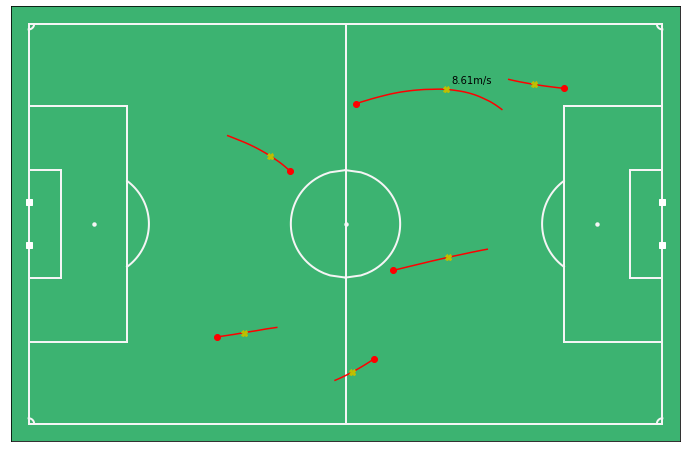

In [26]:
# now plot all the sprints
fig,ax = mviz.plot_pitch()
for s,e in zip(player_sprints_start,player_sprints_end):
    
    ax.plot(tracking_home[column_x].iloc[s],tracking_home[column_y].iloc[s],'ro')
    
    ax.plot(tracking_home[column_x].iloc[s:e+1],tracking_home[column_y].iloc[s:e+1],'r')
    
    # Plus, My implementation on top speeds:
    
    # Make sub df containing frames only from the particular sprint:
    player_sprint = tracking_home.iloc[s:e] 
    
    # Ask for the index where top speed recorded during this sprint:
    speed_index = player_sprint[[column]].idxmax()
    
    # Store x and y of the point where player reached top speed within a run:
    xs = tracking_home[column_x].iloc[speed_index]
    ys = tracking_home[column_y].iloc[speed_index]
    
    # At last, top speed value (in m/s):
    top_speed = player_sprint.loc[speed_index,column].item()
    
    # Yellow cross to denote the moment he reached the highest speed within that run:
    ax.plot(xs, ys, 'yX')
    
    # annotate the sprint where player reached his Peak speed during the whole game (in m/s)
    if top_speed == peak:
        top_speed = round(top_speed, 2) # peak speed rounded to 2 decimal places
        
        plt.annotate('' + str(top_speed) + 'm/s', xy=(xs,ys), 
                     xytext=(xs+1, ys+1) 
                    )